<a href="https://colab.research.google.com/github/miguel-fc/Neutron_Reflect/blob/main/nr_v15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/miguel-fc/Neutron_Reflect.git

Cloning into 'Neutron_Reflect'...
remote: Enumerating objects: 160, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 160 (delta 22), reused 40 (delta 10), pack-reused 106
Receiving objects: 100% (160/160), 14.51 MiB | 23.78 MiB/s, done.
Resolving deltas: 100% (74/74), done.


In [2]:
# Import Python related required packages
import io
import os
import cv2
import gdown
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import plotly.express as px
from sklearn.metrics import mean_squared_error
from scipy.stats import gaussian_kde, norm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error
import pandas as pd
from tqdm import tqdm
import pickle

#Import torch related packages
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split, Dataset, TensorDataset
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
#Set these important parameters
#Dimension of the latent space 
d = 10
#Dimension of the graphs
in_d1 = 2
in_d2 = 72
#Number of epochs
num_epochs = 120
#Number of layers
num_layers = 1
#Number of neurons
num_neur=150 


In [4]:
cd Neutron_Reflect/

/content/Neutron_Reflect


In [5]:
#Stored those numpy arrays
data_path = './data/'
expt_arr = np.load(os.path.join(data_path,'mod_expt.npy'))
# expt_arr_o = np.loadtxt(os.path.join(data_path,'flipped_sorted_no_nano_expt.dat')).T
# expt_arr = np.zeros_like(expt_arr_o)
# # expt_arr[0] = 1791.5076453352374 - expt_arr_o[0]
# expt_arr[0] = expt_arr_o[0]
# expt_arr[1] = expt_arr_o[1]
sld_arr = np.load(os.path.join(data_path,'mod_sld_fp49.npy'))
params_arr = np.load(os.path.join(data_path,'mod_params_fp49.npy'))
# t_sld_arr = np.load(os.path.join(data_path,'train_data.npy'))
# params_arr = np.load(os.path.join(data_path,'train_pars.npy'))

In [6]:
expt_arr.shape ,sld_arr.shape, params_arr.shape, sld_arr.dtype, params_arr.dtype, expt_arr.dtype

((2, 72),
 (5942, 2, 72),
 (5942, 3),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'))

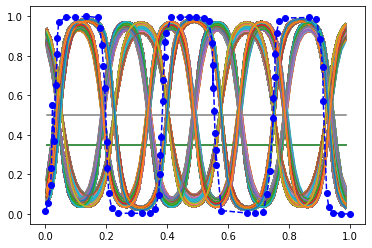

In [7]:
for x in range(sld_arr.shape[0]):
  plt.plot(sld_arr[x][0],sld_arr[x][1])
plt.plot(expt_arr[0],expt_arr[1],'bo',linestyle='dashed')

In [8]:
#Import packages from the github clone
import data_preparation as dpre
import AutoEnc as au
import MLP as mlp

In [9]:
#Prepare data files
xtrain, ytrain, xval, yval, xtest, ytest = \
dpre.split_input_arrays(sld_arr,params_arr, size_split=0.8)

xtrain.shape, ytrain.shape, xval.shape, yval.shape, xtest.shape, ytest.shape
(4753, 2, 72) (4753, 3) (594, 2, 72) (594, 3) (595, 2, 72) (595, 3)


In [10]:
#Prepare data files, continuation
train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader = \
dpre.get_dataloaders_fromsplitarrays(xtrain,ytrain,xval,yval,xtest,ytest,batch_size=50)

In [11]:
loss_fn = torch.nn.MSELoss()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cuda


In [12]:
def initialize_model(d,in_d1,in_d2,num_layers,num_neur):
  lr= 0.001
  torch.manual_seed(0)
  
  encoder = au.Encoder(encoded_space_dim=d,dim1=in_d1,dim2=in_d2,num_layers=num_layers,num_neur=num_neur)
  decoder = au.Decoder(encoded_space_dim=d,dim1=in_d1,dim2=in_d2,num_layers=num_layers,num_neur=num_neur)

  params_to_optimize = [
     {'params': encoder.parameters()},
     {'params': decoder.parameters()}
  ]

  optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)


  return encoder, decoder, optim

In [13]:
#Initialize autoencoder
encoder, decoder, optim = initialize_model(d,in_d1,in_d2,num_layers,num_neur)

#train and validate
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
  # print (epoch)
  train_loss = au.fit(encoder,decoder,device,train_loader,loss_fn,optim)
  val_loss = au.val(encoder,decoder,device,valid_loader,loss_fn)
  print('EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
  diz_loss['train_loss'].append(train_loss)
  diz_loss['val_loss'].append(val_loss)
  # plot_ae_outputs(model,train_dataset,device,n=10)

EPOCH 1/120 	 train loss 0.09093549102544785 	 val loss 0.03086921013891697
EPOCH 2/120 	 train loss 0.005166607443243265 	 val loss 0.00021900789579376578
EPOCH 3/120 	 train loss 0.0001945999829331413 	 val loss 0.00020390226563904434
EPOCH 4/120 	 train loss 0.00017477340588811785 	 val loss 0.00017651726375333965
EPOCH 5/120 	 train loss 0.0001542223762953654 	 val loss 0.0001975732739083469
EPOCH 6/120 	 train loss 0.0001398254680680111 	 val loss 0.00013651092012878507
EPOCH 7/120 	 train loss 0.0001235873205587268 	 val loss 0.0001289079518755898
EPOCH 8/120 	 train loss 0.0001173530108644627 	 val loss 0.0001250301575055346
EPOCH 9/120 	 train loss 0.00010968127025989816 	 val loss 0.00011809041461674497
EPOCH 10/120 	 train loss 0.00010403709165984765 	 val loss 0.00010793804540298879
EPOCH 11/120 	 train loss 9.999002213589847e-05 	 val loss 0.00011242221080465242
EPOCH 12/120 	 train loss 9.580291953170672e-05 	 val loss 0.00010403481428511441
EPOCH 13/120 	 train loss 9.318

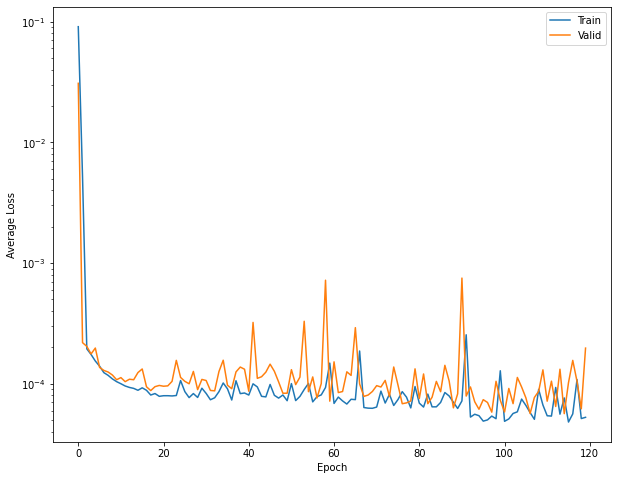

In [14]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.show()

For image 0, the loss = 0.0003215777687728405
For image 1, the loss = 0.00044713428360410035
For image 2, the loss = 0.0002080724952975288
For image 3, the loss = 0.0001361669274047017
For image 4, the loss = 0.0001226043823407963
For image 5, the loss = 8.32990845083259e-05
For image 6, the loss = 0.00014816434122622013
For image 7, the loss = 0.00045237416634336114
For image 8, the loss = 0.000470448489068076
For image 9, the loss = 0.00016683264402672648


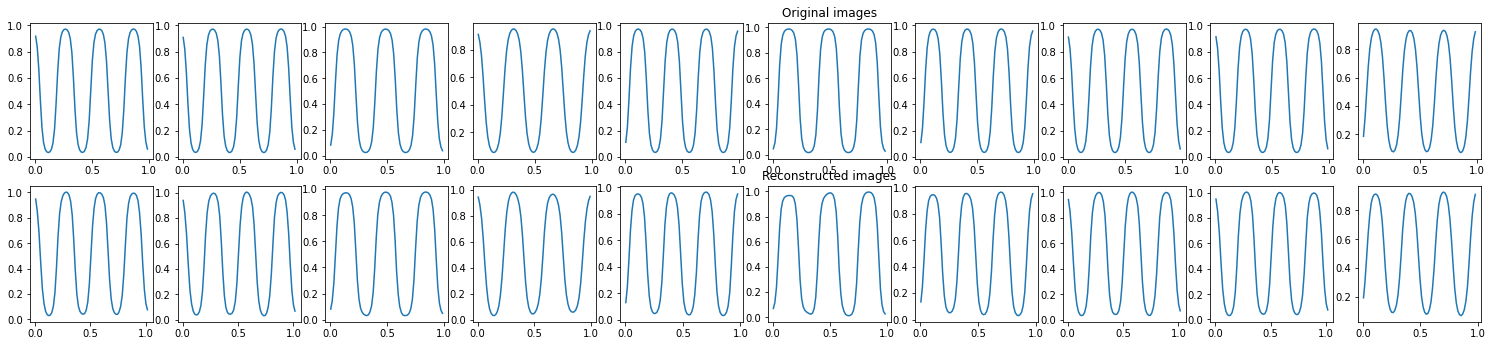

In [15]:
au.test(encoder,decoder,test_dataset,device,loss_fn,in_d1,in_d2,n=10)

tensor([-2.1950,  1.1193,  1.7261,  0.6928, -0.8913, -1.6803, -2.0674, -1.2638,
         0.4753,  2.0834])
tensor([0.7625, 1.4182, 1.3597, 1.4557, 1.4702, 1.1532, 1.5296, 0.8758, 1.4837,
        0.6376])


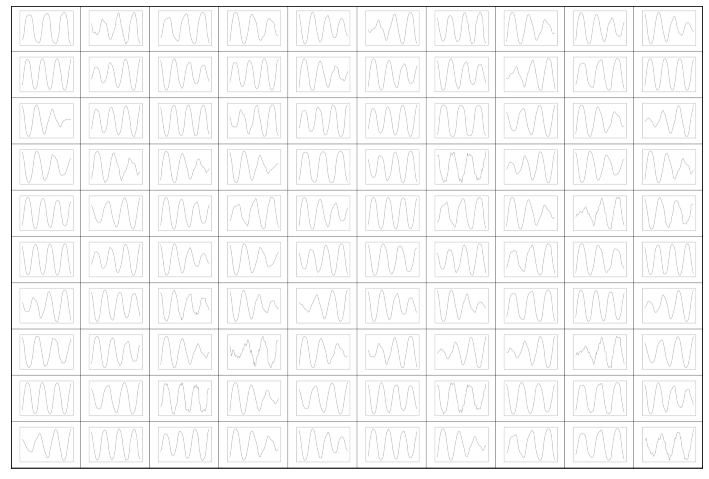

In [16]:
#Interpolating in the latent space
#This is similar to a manifold

def get_img_from_fig(fig, dpi=180):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=dpi)
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    plt.close()
    img = cv2.imdecode(img_arr,0)

    return img

def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.set_xticks([])
    ax.set_yticks([])

encoder.eval()
decoder.eval()

with torch.no_grad():
    images, labels = iter(train_loader).next()
    images = images.view(images.size(0), -1).to(device) 

    latent = encoder(images)
    latent = latent.cpu()

    mean = latent.mean(dim=0)
    print(mean)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()
    print(std)


    latent = torch.randn(200, d)*std + mean
    latent = latent.to(device)
    img_recon = decoder(latent)
    img_recon = img_recon.view(img_recon.size(0), in_d1,in_d2).cpu()


n_img = []
for i in range(img_recon.shape[0]):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.close()
    ax.plot(img_recon[i][0],img_recon[i][1])
    n_img.append(get_img_from_fig(fig))

n_img = torch.from_numpy(np.asarray(n_img))
n_img = n_img[:,np.newaxis,:,:]

fig, ax = plt.subplots(figsize=(20, 8.5))
show_image(torchvision.utils.make_grid(n_img[:100],10,5))
plt.show()

In [17]:
nlabel = params_arr.shape[1]
# nlabel

for i in range(nlabel):
  label_index = 'label'+str(i)
  print(label_index)

label0
label1
label2


In [18]:
encoded_samples = []
for sample in train_dataset:
    img = sample[0].unsqueeze(0)
    img = img.view(img.size(0), -1).to(device) 
    label_val = sample[1]
    # print(label_val.shape)
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    encoded_img = encoded_img.flatten().cpu().numpy()
    # print(enumerate(encoded_img))
    encoded_sample = {f"l{i+1}": enc for i, enc in enumerate(encoded_img)}
    for i in range(nlabel):
      label_index = 'label'+str(i)
      encoded_sample[label_index] = label_val[i].numpy()
    # encoded_sample['label1'] = label[1].numpy()
    # encoded_sample['label2'] = label[2].numpy()
    # encoded_sample['label3'] = label[3].numpy()
    encoded_samples.append(encoded_sample)
df_encoded_samples = pd.DataFrame(encoded_samples)
df_encoded_samples

,l1,l2,l3,l4,l5,l6,l7,l8,l9,l10,label0,label1,label2
0,-1.150611,0.271770,3.911490,3.002361,1.373187,-2.946725,-2.519060,-0.881800,0.458742,1.015557,0.2,-0.256,-0.3447
1,-1.165348,0.243483,3.913290,2.984066,1.351914,-2.922500,-2.553694,-0.863418,0.423790,1.021361,0.11,-0.367,-0.27623
2,-2.824073,-0.726864,2.225328,0.044581,-1.713575,-0.469317,-4.170746,-0.085745,-1.595452,2.174667,0.174,-0.358,0.51519
3,-2.822487,-0.723117,2.213670,0.036293,-1.718549,-0.463506,-4.161902,-0.086460,-1.593006,2.174279,0.162,-0.113,0.46644
4,-1.547220,2.659812,1.512119,1.492760,0.050268,-2.875000,-0.274988,-2.264490,2.293876,1.901459,0.0603,0.0119,-0.43713
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4748,-1.596342,2.716285,1.377504,1.361636,-0.072184,-2.803692,-0.229471,-2.289331,2.305705,1.955922,0.0814,0.191,-0.18848
4749,-3.026434,1.870677,-0.096183,-1.188307,-2.722553,-0.669146,-1.621803,-1.609902,0.551363,2.953871,0.108,0.082,0.01623
4750,-1.512066,2.959946,1.327223,1.460476,0.046272,-2.977235,0.045960,-2.447473,2.582894,1.943937,0.147,0.0879,-0.20558
4751,-2.951952,1.779699,0.068144,-1.028332,-2.564482,-0.741686,-1.678621,-1.562126,0.520758,2.870180,0.0907,0.402,0.03634


In [19]:
pepe = np.asarray(encoded_samples)

In [20]:
pepe.shape


(4753,)

In [21]:
#Creating dataloaders for the MLP. This includes train, valid and test

img, out_img, train_latent_var, train_labels_var = au.get_latent_variables(encoder,decoder,device,train_loader)
print(img.shape, out_img.shape, train_latent_var.shape, train_labels_var.shape)

img, out_img, valid_latent_var, valid_labels_var = au.get_latent_variables(encoder,decoder,device,valid_loader)
print(img.shape, out_img.shape, valid_latent_var.shape, valid_labels_var.shape)


img, out_img, test_latent_var, test_labels_var = au.get_latent_variables(encoder,decoder,device,test_loader)
print(img.shape, out_img.shape, test_latent_var.shape, test_labels_var.shape)


mlp_train_dataset, mlp_valid_dataset, mlp_test_dataset, mlp_train_loader, mlp_valid_loader, mlp_test_loader = \
dpre.get_dataloaders_fromsplitarrays(train_latent_var.numpy(),train_labels_var.numpy(), \
                                valid_latent_var.numpy(),valid_labels_var.numpy(),\
                                test_latent_var.numpy(),test_labels_var.numpy(), \
                                batch_size=50)

torch.Size([4753, 144]) torch.Size([4753, 144]) torch.Size([4753, 10]) torch.Size([4753, 3])
torch.Size([594, 144]) torch.Size([594, 144]) torch.Size([594, 10]) torch.Size([594, 3])
torch.Size([595, 144]) torch.Size([595, 144]) torch.Size([595, 10]) torch.Size([595, 3])


In [22]:
num_epochs = 1600
num_layers = 1
num_neur = 500

def initialize_mlp(dim,nlabel,num_layers,num_neur):
  lr= 0.001
  torch.manual_seed(0)
  
  model = mlp.MLP(dim=d,nlabel=nlabel,num_layers=num_layers,num_neur=num_neur)

  params_to_optimize = [
     {'params': model.parameters()},
  ]

  optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)


  return model, optim

In [23]:
#Initialize mlp
model, optim = initialize_mlp(d,nlabel,num_layers,num_neur)
model.to(device)

MLP(
  (mlp): Sequential(
    (0): Linear(in_features=10, out_features=500, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=500, out_features=3, bias=True)
  )
)

In [24]:
#Initialize mlp
model, optim = initialize_mlp(d,nlabel,num_layers,num_neur)

#Train and validate
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
  # print (epoch)
  train_loss = mlp.fit(model,device,mlp_train_loader,loss_fn,optim)
  val_loss = mlp.val(model,device,mlp_valid_loader,loss_fn)
  print('EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
  diz_loss['train_loss'].append(train_loss)
  diz_loss['val_loss'].append(val_loss)

EPOCH 1/1600 	 train loss 0.03156748041510582 	 val loss 0.023333892226219177
EPOCH 2/1600 	 train loss 0.021479502320289612 	 val loss 0.024848612025380135
EPOCH 3/1600 	 train loss 0.020555982366204262 	 val loss 0.022244922816753387
EPOCH 4/1600 	 train loss 0.02052510343492031 	 val loss 0.018698152154684067
EPOCH 5/1600 	 train loss 0.019450442865490913 	 val loss 0.02320295013487339
EPOCH 6/1600 	 train loss 0.018980232998728752 	 val loss 0.016952762380242348
EPOCH 7/1600 	 train loss 0.017909497022628784 	 val loss 0.021196087822318077
EPOCH 8/1600 	 train loss 0.01760106533765793 	 val loss 0.017758194357156754
EPOCH 9/1600 	 train loss 0.01669028401374817 	 val loss 0.018910080194473267
EPOCH 10/1600 	 train loss 0.016688980162143707 	 val loss 0.015884380787611008
EPOCH 11/1600 	 train loss 0.015812596306204796 	 val loss 0.01699628308415413
EPOCH 12/1600 	 train loss 0.015695877373218536 	 val loss 0.015371317975223064
EPOCH 13/1600 	 train loss 0.015513722784817219 	 val l

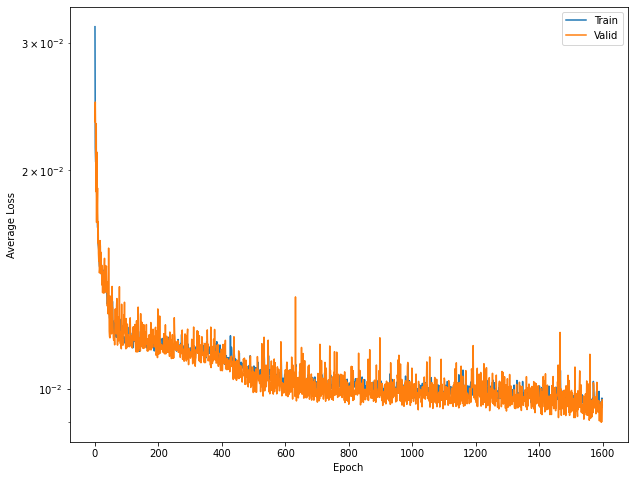

In [25]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

In [26]:
out_samples = []
for sample in mlp_test_dataset:
    img = sample[0]
    img = img.to(device) 
    label_val = sample[1]
    # print(label_val.shape)
    model.eval()
    with torch.no_grad():
        out_label  = model(img)
    out_label = out_label.cpu().numpy()
    # print(enumerate(encoded_img))
    out_sample = {f"pred_label{i}": enc for i, enc in enumerate(out_label)}
    for i in range(nlabel):
      label_index = 'label'+str(i)
      out_sample[label_index] = label_val[i].numpy()
    out_samples.append(out_sample)
df_out_samples = pd.DataFrame(out_samples)
df_out_samples

,pred_label0,pred_label1,pred_label2,label0,label1,label2
0,0.154474,-0.319920,0.484906,0.183,-0.0262,0.33102
1,0.150468,-0.482621,-0.184555,0.149,-0.491,-0.1749
2,0.146004,0.471446,-0.220636,0.179,0.572,-0.38085
3,0.065850,-0.366427,0.303835,0.0641,-0.569,0.36608
4,0.149245,0.210216,0.407500,0.141,0.154,0.41239
...,...,...,...,...,...,...
590,0.147435,0.338561,0.278499,0.188,0.302,0.29152
591,0.150337,-0.323948,0.111556,0.171,-0.371,0.11494
592,0.150654,-0.327809,0.442273,0.198,-0.273,0.51022
593,0.061309,0.386853,0.208316,0.0509,0.222,0.08003


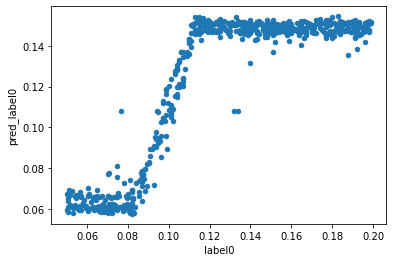

In [27]:
df_out_samples.plot(x ='label0', y='pred_label0', kind = 'scatter')
plt.show()

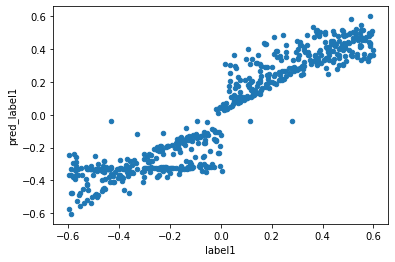

In [28]:
df_out_samples.plot(x ='label1', y='pred_label1', kind = 'scatter')
plt.show()

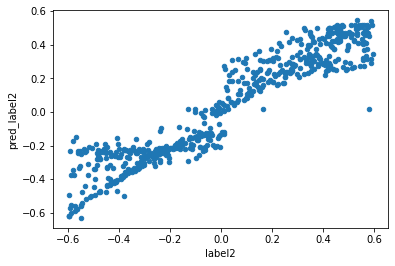

In [29]:
df_out_samples.plot(x ='label2', y='pred_label2', kind = 'scatter')
plt.show()

In [30]:
expt_arr_n = expt_arr[np.newaxis,:,:]
expt_arr_n.shape

(1, 2, 72)

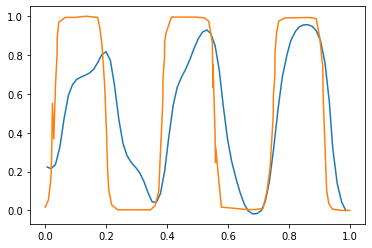

In [31]:
img = torch.from_numpy(expt_arr_n[0]).float()
img=torch.flatten(img).to(device)

encoder.eval().to(device)
decoder.eval().to(device)

with torch.no_grad():
  decoded_img = decoder(encoder(img))


plt.plot(decoded_img.cpu().reshape(in_d1,in_d2).numpy()[0],decoded_img.cpu().reshape(in_d1,in_d2).numpy()[1]) 
plt.plot(expt_arr_n[0][0],expt_arr_n[0][1])
